In [135]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import json
import csv
import pandas
import re
from pandas.io.json import json_normalize 
import matplotlib.pyplot as plt 

0    False
1    False
2    False
3    False
4    False
Name: itemType, dtype: bool
/home/billtrust.local/bmccarthy/.local/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.


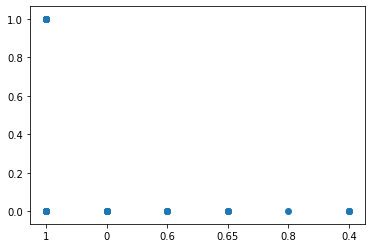

In [138]:
with open('output/losangeles.eventful.com!events!categories!music.json') as f: 
    d = json.load(f) 
    df = json_normalize(d["elements"]) 

    df.fontSize = df.fontSize.apply(lambda x : re.sub("[^0-9]", "", x))
    df.lineHeight = df.lineHeight.apply(lambda x : re.sub("[^0-9]", "", x))
    df.itemType = df.itemType.apply(lambda x : "http://schema.org/Event" == x)

    y = df.itemType
    X = df.drop(labels=["color", "elementId", "tagName", "classList", "textContent", "font", "fontStyle", "backgroundColor", "background", "backgroundImage", "itemType", "itemProp"], axis=1)

    xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size = 0.2, random_state = 42)

    X.to_csv("output/losangeles.eventful.com!events!categories!music.csv")
    # print(xTrain.head(5))
    print(y.head(5))
    yTrain.to_csv("output/testYTrain.csv")
    # print(yTrain)

    plt.scatter(X.opacity, y)
    plt.show()
